# IMPORT LIBRARIES

In [19]:
# for data visualization
import matplotlib.pyplot as plt
# for numerical analysis
import numpy as np
# to build model
import tensorflow as tf
# for df manipulation
import pandas as pd
# for visulaization also
import seaborn as sns
# used to load our data
import pickle
# to generate random numbers
import random
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import classification_report

# Dataset Loading

In [2]:
# open the data into "read binary" mode 
# and assign the data into train, valid and test 
with open("./train.p", mode='rb') as training_data:
    train = pickle.load(training_data)
# to perform cross validation and avoid overfitting
with open("./valid.p", mode='rb') as validation_data:
    valid = pickle.load(validation_data)
with open("./test.p", mode='rb') as testing_data:
    test = pickle.load(testing_data)

# Extract Features

In [3]:
X_train, y_train = train['features'], train['labels']
X_val, y_val = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
# each image is 32x32px and with 3 channels RGB


print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)
(34799,)
(4410,)
(12630,)


# PERFORM IMAGES VISUALIZATION

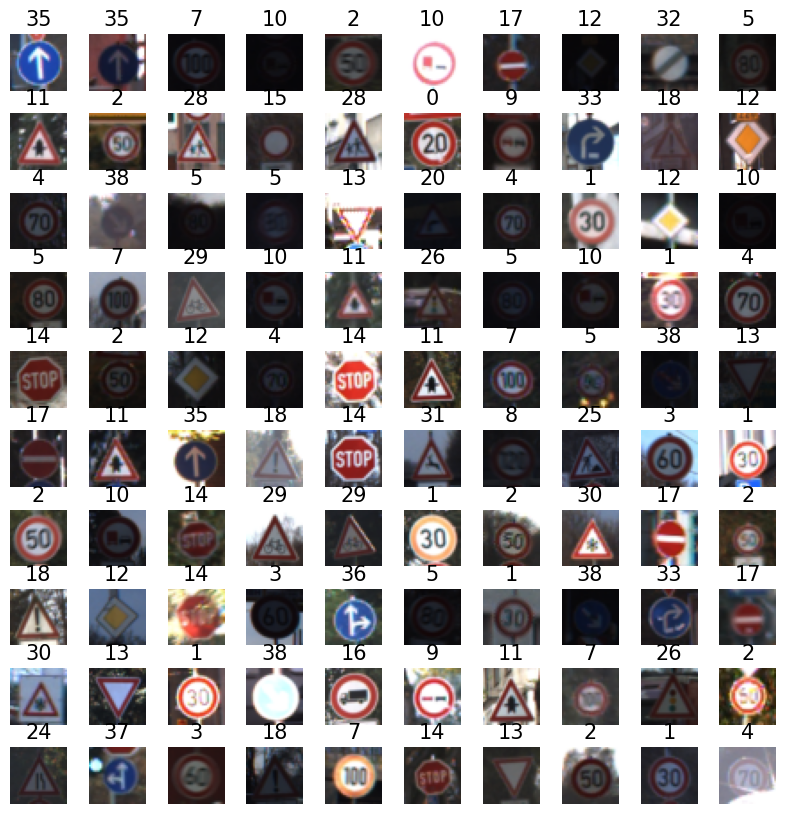

In [4]:
# performing sanity check (making sure that the labels 
# and the data make sense and accurate
# select random number between 1 and length of train data
i = np.random.randint(1, len(X_train))
# Let's view more images in a grid format

# Define the dimensions of the plot grid 
W_grid = 10
L_grid = 10

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (10,10))

axes = axes.ravel() # flaten the 5 x 5 matrix into 25 array

n_training = len(X_train) # get the length of the training dataset

# Select a random number from 0 to n_training
# create evenly spaces variables 
for i in np.arange(0, W_grid * L_grid):
    # Select a random number
    index = np.random.randint(0, n_training)
    # read and display an image with the selected index    
    axes[i].imshow(X_train[index])
    axes[i].set_title(y_train[index], fontsize = 15)
    axes[i].axis('off')
# create spacing between images
plt.subplots_adjust(hspace = 0.4)

# CONVERT IMAGES TO GRAYSCALE AND PERFORM NORMALIZATION

In [5]:
# shuffle to make sure the network doesn't learn the order of the images
# e.g. feeding it 100 stop signs back to back
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)


#convert image from RGB to greyscale
# taking all the RGB pixels and averaging it
X_train_gray = np.sum(X_train/3, axis = 3, keepdims = True)
X_val_gray = np.sum(X_val/3, axis = 3, keepdims = True)
X_test_gray = np.sum(X_test/3, axis = 3, keepdims = True)

# normalize the images
# instead of having pixels from 0 to 255
X_train_gray_norm = (X_train_gray - 128)/128
X_val_gray_norm = (X_val_gray - 128)/128
X_test_gray_norm = (X_test_gray - 128)/128

In [6]:
print(X_train_gray.shape)
print(X_val_gray.shape)
print(X_test_gray.shape)
# now each 32x32px with 1 dim

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


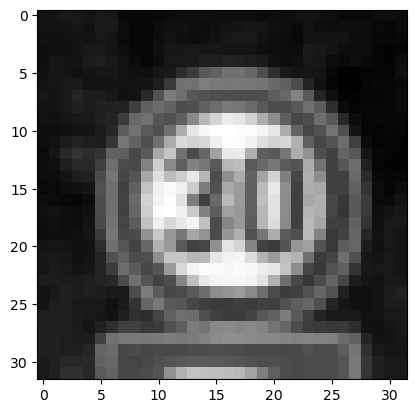

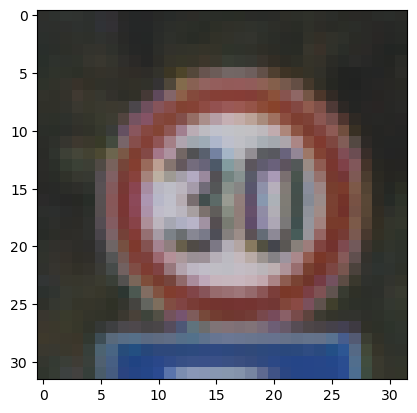

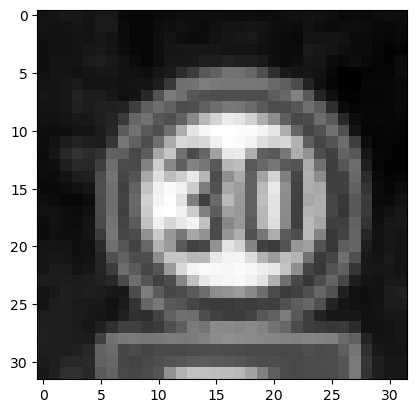

In [7]:
# visualizing the RGB (original), greyscale and normalized image
i = random.randint(1, len(X_train_gray))
plt.imshow(X_train_gray[i].squeeze(), cmap = 'gray')
plt.figure()
plt.imshow(X_train[i])
plt.figure()
plt.imshow(X_train_gray_norm[i].squeeze(), cmap = 'gray')

# BUILD DEEP CONVOLUTIONAL NEURAL NETWORK MODEL

In [8]:
CNN = models.Sequential()

CNN.add(layers.Conv2D(6, (5, 5), activation = 'relu', input_shape = (32, 32, 1)))
CNN.add(layers.AveragePooling2D(2, 2))

CNN.add(layers.Dropout(0.2))

CNN.add(layers.Conv2D(16, (5, 5), activation = 'relu'))
CNN.add(layers.AveragePooling2D(2, 2))

CNN.add(layers.Flatten())

CNN.add(layers.Dense(120, activation = 'relu'))
CNN.add(layers.Dense(84, activation = 'relu'))
# output
CNN.add(layers.Dense(43, activation = 'softmax'))
CNN.summary()

/Users/razan./anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 43)             │         3,655 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,511 (252.00 KB)

 Trainable params: 64,511 (252.00 KB)

 Non-trainable params: 0 (0.00 B)

# COMPILE AND TRAIN DEEP CNN MODEL

In [9]:
# since we have 43 classes i will use sparse crossentropy
CNN.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [10]:
history = CNN.fit(X_train_gray_norm,
                  y_train,
                  batch_size = 100,
                  epochs = 60,
                  verbose = 1,
                  validation_data = (X_val_gray_norm, y_val))

Epoch 1/60
348/348 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.2351 - loss: 2.8706 - val_accuracy: 0.6914 - val_loss: 1.0453
Epoch 2/60
348/348 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.7440 - loss: 0.8567 - val_accuracy: 0.8023 - val_loss: 0.6556
Epoch 3/60
348/348 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.8460 - loss: 0.5130 - val_accuracy: 0.8562 - val_loss: 0.5278
Epoch 4/60
348/348 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.8939 - loss: 0.3687 - val_accuracy: 0.8449 - val_loss: 0.5833
Epoch 5/60
348/348 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.9183 - loss: 0.2850 - val_accuracy: 0.8730 - val_loss: 0.4412
Epoch 6/60
348/348 ━━━━━━━━━━━━━━━━━━━━ 27s 67ms/step - accuracy: 0.9333 - loss: 0.2195 - val_accuracy: 0.8866 - val_loss: 0.4143
Epoch 7/60
348/348 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - accuracy: 0.9488 - loss: 0.1803 - val_accuracy: 0.8896 - val_loss: 0.3937
Epoch 8/60
348/348 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.9527 - loss: 0.1551 - 

# ASSESS TRAINED CNN MODEL PERFORMANCE

In [11]:
score = CNN.evaluate(X_test_gray_norm, y_test)
print('Test Accuracy: {}'.format(score[1]))

print('with dropout = 0.2 and batch size = 500 Test Accuracy: 0.9019002318382263')
print('with dropout = 0.6 and batch size = 100 Test Accuracy: 0.9156769514083862')
# *BEST FOUND TUNING*
print('with dropout =0.2 and 0.6 and batch size = 100 Test Accuracy: 0.945209801197052')

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9217 - loss: 0.6849
Test Accuracy: 0.9191607236862183
with dropout = 0.2 and batch size = 500 Test Accuracy: 0.9019002318382263
with dropout = 0.6 and batch size = 100 Test Accuracy: 0.9156769514083862
with dropout =0.2 and 0.6 and batch size = 100 Test Accuracy: 0.945209801197052


In [12]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [13]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and validation loss')

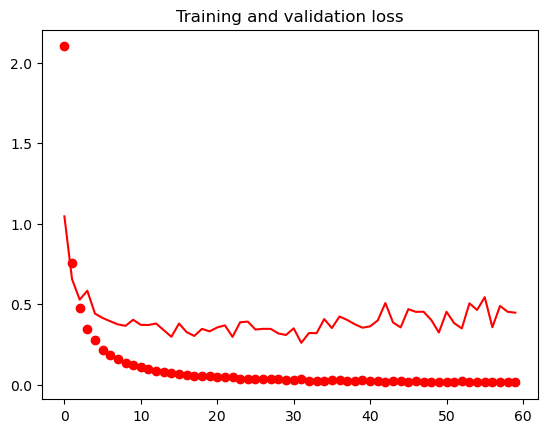

In [14]:
epochs = range(len(accuracy))
plt.plot(epochs, loss, 'ro', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Training and validation loss')

Text(0.5, 1.0, 'Training and validation Accuracy')

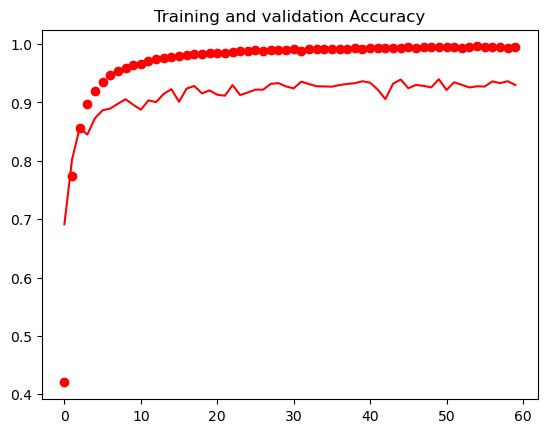

In [15]:
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'ro', label = 'Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label = 'Validation Accuracy')
plt.title('Training and validation Accuracy')

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


<Axes: >

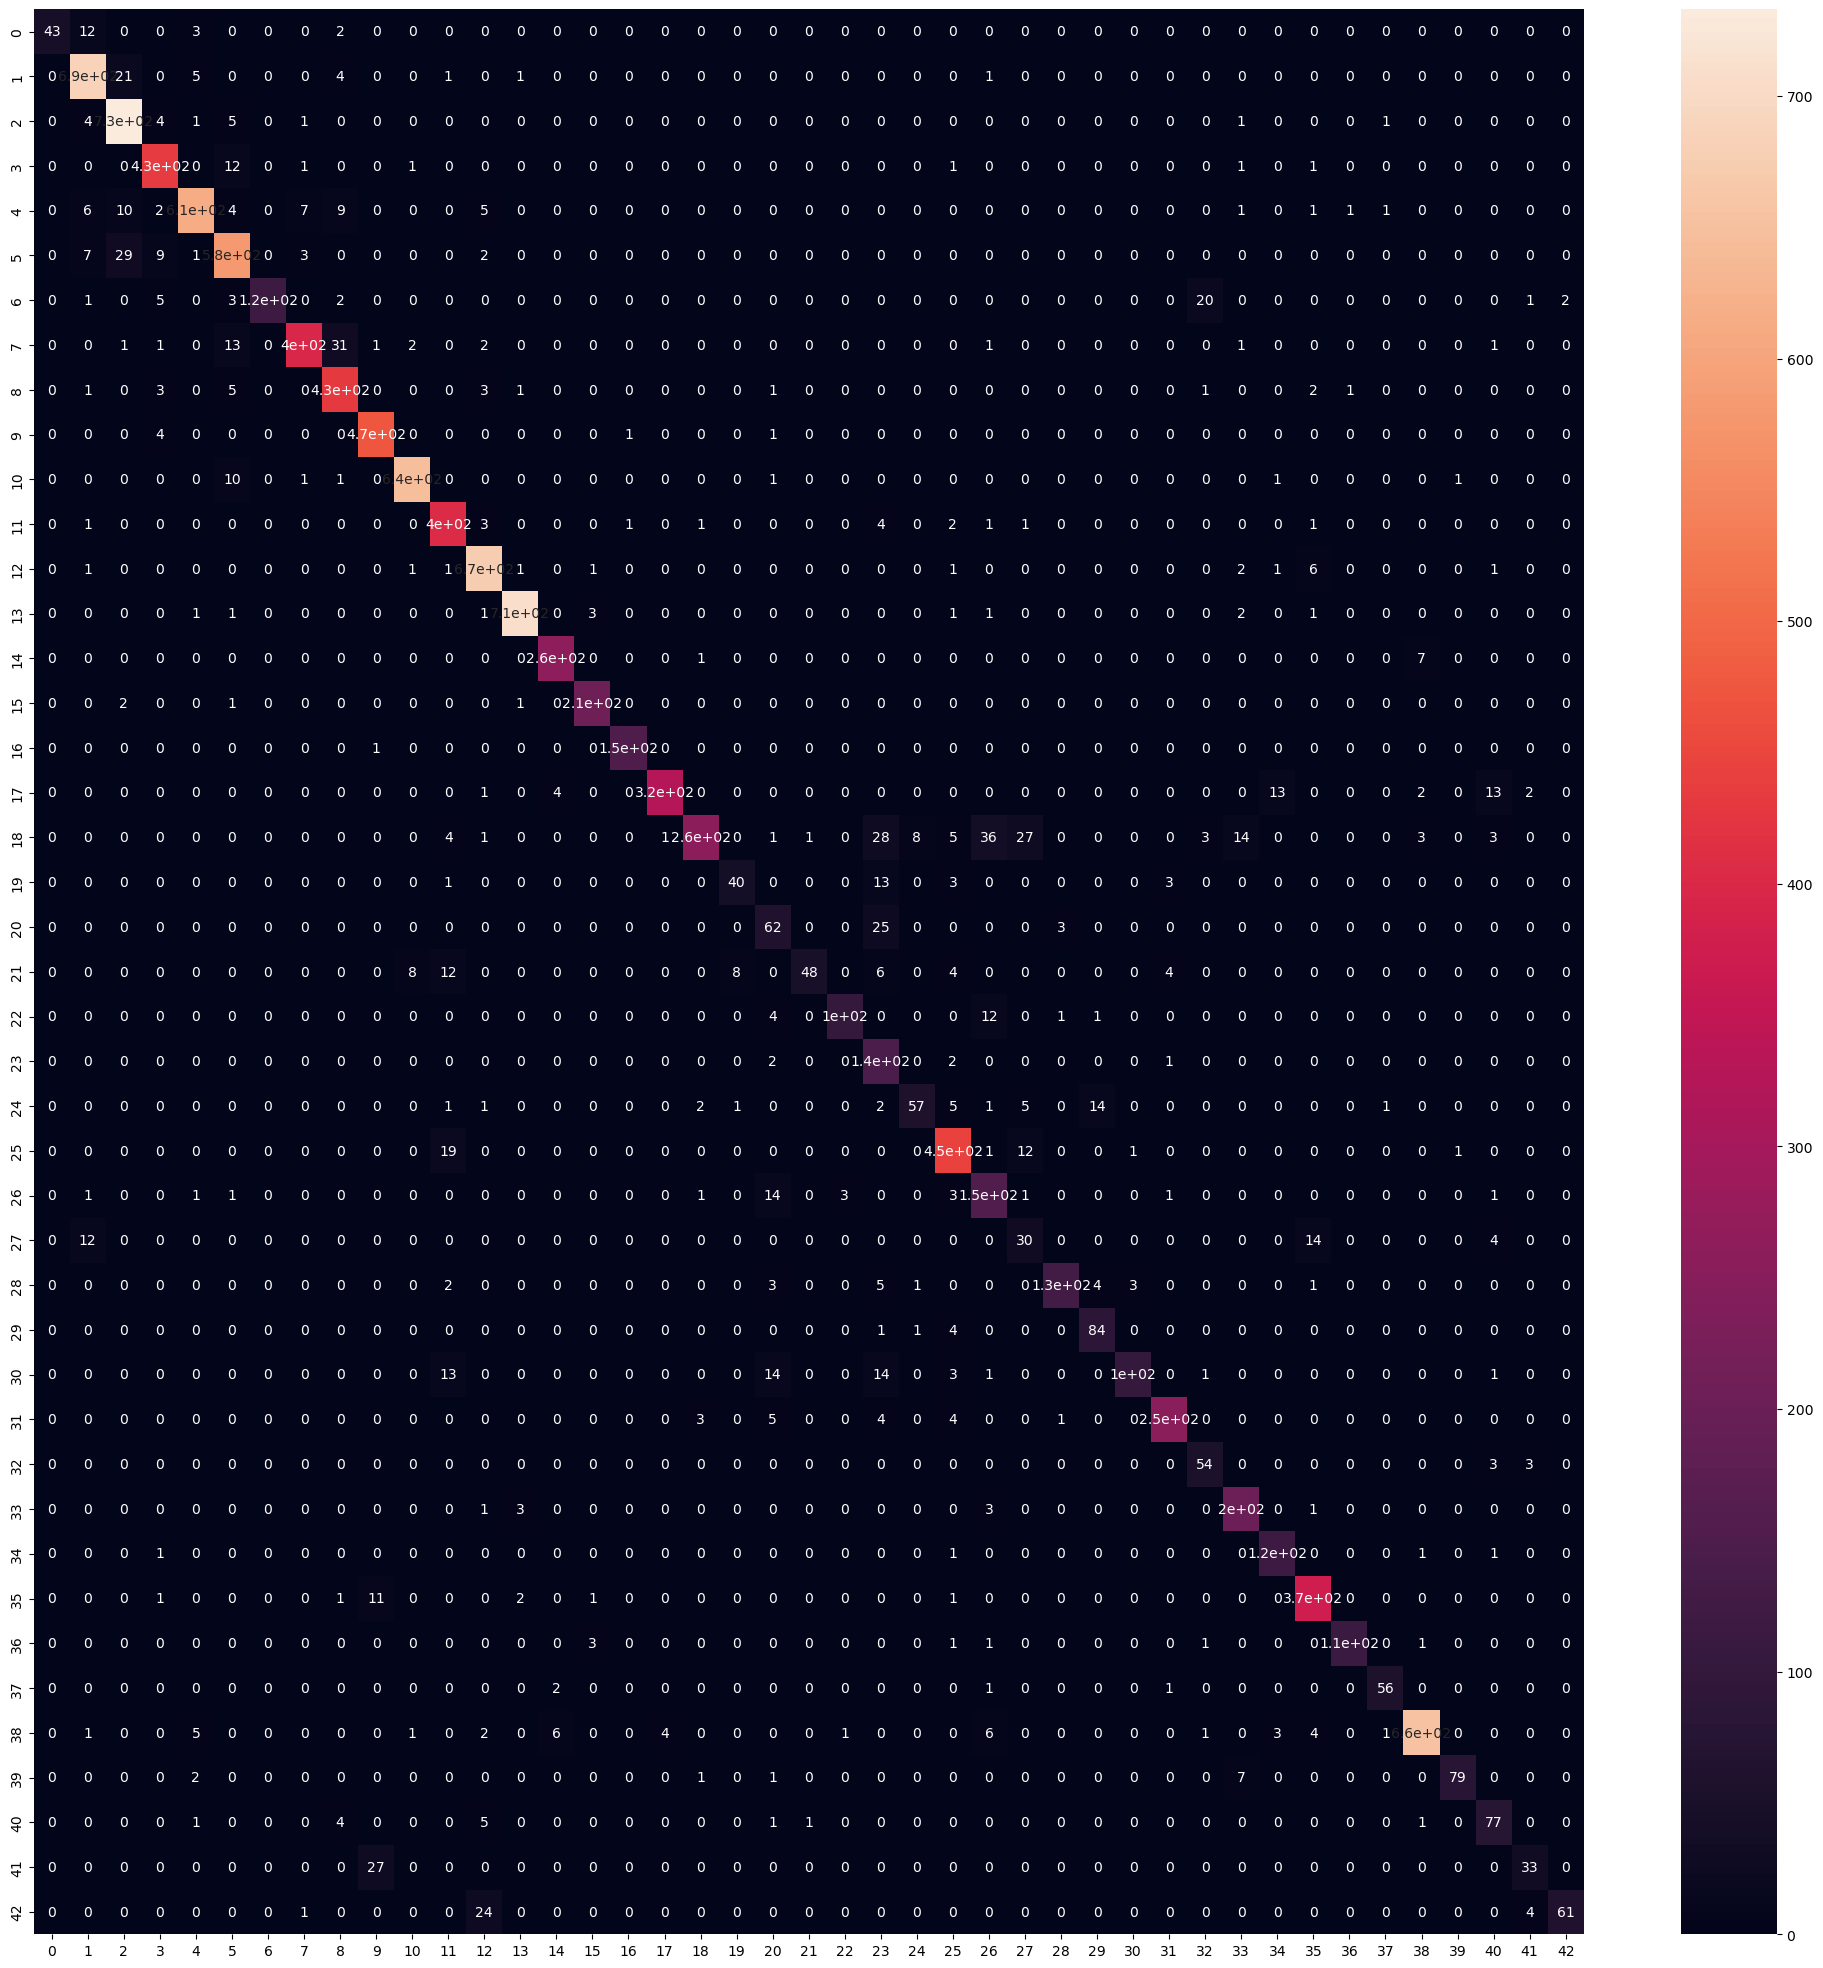

In [16]:
predicted_classes = CNN.predict(X_test_gray_norm)
y_true = y_test
# Convert probabilities to class labels
predicted_classes = np.argmax(predicted_classes, axis=1)
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (25, 25))
sns.heatmap(cm, annot = True)

In [20]:
# classification report
print(classification_report(y_true, predicted_classes))

              precision    recall  f1-score   support

           0       1.00      0.72      0.83        60
           1       0.94      0.95      0.94       720
           2       0.92      0.98      0.95       750
           3       0.94      0.96      0.95       450
           4       0.97      0.93      0.95       660
           5       0.91      0.92      0.92       630
           6       1.00      0.77      0.87       150
           7       0.97      0.88      0.92       450
           8       0.89      0.96      0.92       450
           9       0.92      0.99      0.95       480
          10       0.98      0.98      0.98       660
          11       0.88      0.96      0.92       420
          12       0.93      0.98      0.95       690
          13       0.99      0.98      0.99       720
          14       0.96      0.97      0.96       270
          15       0.96      0.98      0.97       210
          16       0.99      0.99      0.99       150
          17       0.98    

In [17]:
precision = precision_score(y_true, predicted_classes, average = 'weighted')
print("Precision: ", precision)
recall = recall_score(y_true, predicted_classes, average = 'weighted')
print("Recall: ", recall)
f1_score = f1_score(y_true, predicted_classes, average = 'weighted')
print("f1_score: ", f1_score)

Precision:  0.926057071550433
Recall:  0.9191607284243863
f1_score:  0.9188352836999399


NameError: name 'classification_report' is not defined

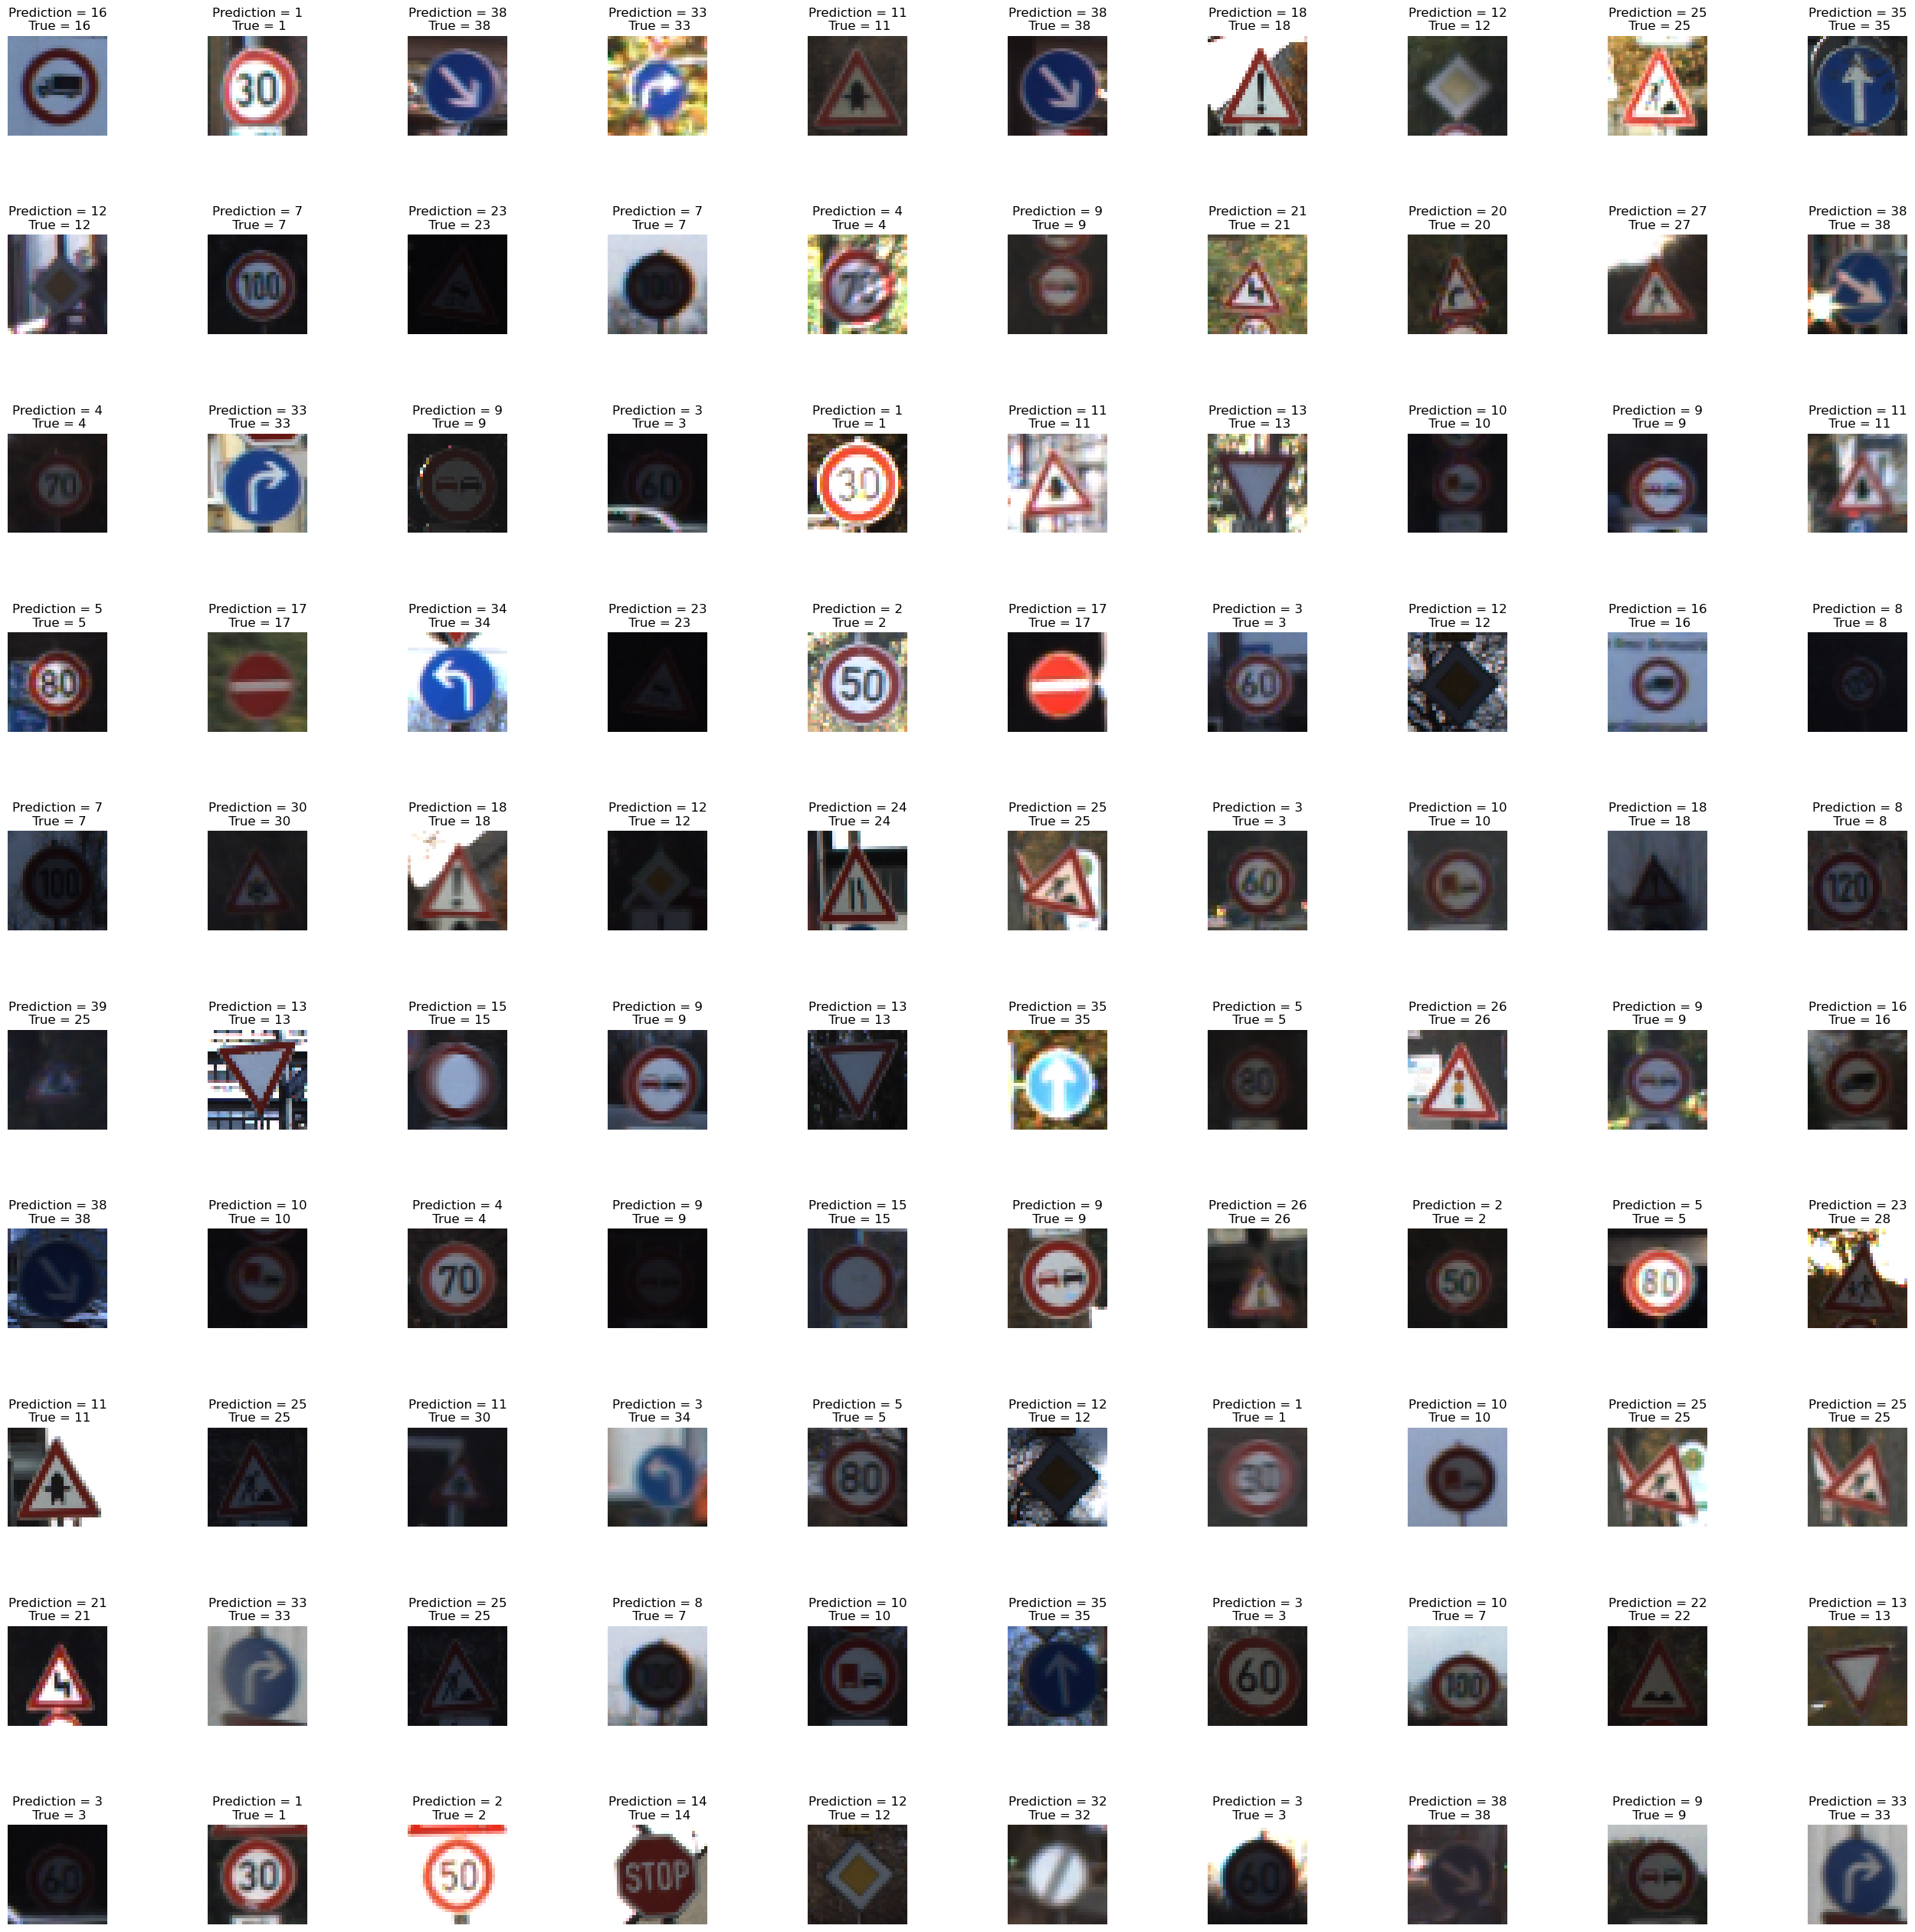

In [21]:
L = 10
W = 10

fig, axes = plt.subplots(L, W, figsize = (32, 32))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(X_test[i])
    axes[i].set_title('Prediction = {}\n True = {}'.format(predicted_classes[i], y_true[i]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1, hspace = 1)

# APPENDIX

- In this case study, we want to classify images of traffic signs using deep Convolutional Neural Networks (CNNs).
- The dataset consists of 43 different classes of images.
- Classes are as listed below:
- 0 = Speed limit (20km/h)
- 1 = Speed limit (30km/h)
- 2 = Speed limit (50km/h)
- 3 = Speed limit (60km/h)
- 4 = Speed limit (70km/h)
- 5 = Speed limit (80km/h)
- 6 = End of speed limit (80km/h)
- 7 = Speed limit (100km/h)
- 8 = Speed limit (120km/h)
- 9 = No passing
- 10 = No passing for vehicles over 3.5 metric tons
- 11 = Right-of-way at the next intersection
- 12 = Priority road
- 13 = Yield
- 14 = Stop
- 15 = No vehicles
- 16 = Vehicles over 3.5 metric tons prohibited
- 17 = No entry
- 18 = General caution
- 19 = Dangerous curve to the left
- 20 = Dangerous curve to the right
- 21 = Double curve
- 22 = Bumpy road
- 23 = Slippery road
- 24 = Road narrows on the right
- 25 = Road work
- 26 = Traffic signals
- 27 = Pedestrians
- 28 = Children crossing
- 29 = Bicycles crossing
- 30 = Beware of ice/snow
- 31 = Wild animals crossing
- 32 = End of all speed and passing limits
- 33 = Turn right ahead
- 34 = Turn left ahead
- 35 = Ahead only
- 36 = Go straight or right
- 37 = Go straight or left
- 38 = Keep right
- 39 = Keep left
- 40 = Roundabout mandatory
- 41 = End of no passing
- 42 = End of no passing by vehicles over 3.5 metric tons